In [1]:
import tensorflow as tf
import tensorflow.keras as keras

# !pip install tensorflow-addons
import tensorflow_addons as tfa

# !pip install git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
import os

np.set_printoptions(threshold=sys.maxsize)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-9d2oxoc6
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-9d2oxoc6


In [2]:
def get_cifar_10():
  (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
  assert x_train.shape == (50000, 32, 32, 3)
  assert x_test.shape == (10000, 32, 32, 3)
  assert y_train.shape == (50000, 1)
  assert y_test.shape == (10000, 1)
  x_train = x_train.astype('float')
  x_test = x_test.astype('float')
  y_train = y_train.astype('int32')
  y_test = y_test.astype('int32')
  # per-pixel subtraction
  # train
  per_px_mean = np.zeros((32, 32, 3))
  for i in range(50000):
    per_px_mean += x_train[i, ...]
  per_px_mean /= 50000
  for i in range(50000):
    x_train[i, ...] -= per_px_mean
  

  #test
  per_px_mean = np.zeros((32, 32, 3))
  for i in range(10000):
    per_px_mean += x_test[i, ...]
  per_px_mean /= 10000
  for i in range(10000):
    x_test[i, ...] -= per_px_mean

  # padding
  x_train_padded = np.zeros((50000, 40, 40, 3))
  for i in range(50000):
    for j in range(3):
      x_train_padded[i, :, :, j] = np.pad(x_train[i, :, :, j], 4)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train_padded, y_train))
  test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
  return train_ds, test_ds

We follow the simple data augmen- tation in [24] for training: 4 pixels are padded on each side, and a 32×32 crop is randomly sampled from the padded image or its horizontal flip. For testing, we only evaluate the single view of the original 32×32 image.

In [3]:
def augmentation(img, label):
  seq = tf.keras.Sequential([
      tf.keras.layers.RandomFlip("horizontal"),
      tf.keras.layers.RandomCrop(32, 32)
  ])
  return seq(img), label

In [4]:
train_and_val_ds, test_ds = get_cifar_10()

In [5]:
encoding = tf.keras.layers.CategoryEncoding(num_tokens=10, output_mode='one_hot')
# augmentation
train_and_val_ds = train_and_val_ds.map(augmentation, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
test_ds = test_ds.map(augmentation, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
# label encoding
train_and_val_ds = train_and_val_ds.map(lambda x, y : (x, encoding(y)), num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
test_ds = test_ds.map(lambda x, y : (x, encoding(y)), num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)

We use a weight decay of 0.0001 and momentum of 0.9, and adopt the weight initialization in [12] and BN [16] but with no dropout. These models are trained with a mini- batch size of 128 on two GPUs. We start with a learning rate of 0.1, divide it by 10 at 32k and 48k iterations, and terminate training at 64k iterations, which is determined on a 45k/5k train/val split. 

In [9]:
class LearningRateReducerCb(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if epoch == 32000 or epoch == 48000:
      old_lr = self.model.optimizer.lr.read_value()
      new_lr = old_lr / 10
      print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
      self.model.optimizer.lr.assign(new_lr)

In [6]:
train_size = 45000
val_size = 5000

batch_size = 128
train_and_val_ds.shuffle(train_size + val_size)
val_ds = train_and_val_ds.skip(val_size).batch(batch_size)
train_ds = train_and_val_ds.take(train_size).batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [10]:
opt = tfa.optimizers.SGDW(learning_rate=0.1, weight_decay=0.0001, momentum=0.9)
epochs = 250

In [11]:
from tensorflow.keras import layers, Sequential

class ResBlk(layers.Layer):
    def __init__(self, out_chan, strides = 1, downsample = None, **kwargs):
        super().__init__()
        
        self.conv1 = layers.Conv2D(out_chan, padding='same', kernel_size=3, strides=strides)
        self.bn1 = layers.BatchNormalization()
        self.relu1 = layers.ReLU()
        
        self.conv2 = layers.Conv2D(out_chan, padding='same', kernel_size=3, strides=1)
        self.bn2 = layers.BatchNormalization()
        
        self.downsample = downsample
        
        self.relu2 = layers.ReLU()

    
    def call(self, X, training = False, **kwargs):
        y = X
        
        y = self.conv1(y)
        y = self.bn1(y, training)
        y = self.relu1(y)

        
        y = self.conv2(y)
        y = self.bn2(y, training)
        
        h_x = X

        if self.downsample != None:
            h_x = self.downsample(h_x)

        y += h_x
        y = self.relu2(y)

        return y

class ResNet_on_cifar(tf.keras.Model):
  def __init__(self, n, blkType = ResBlk, **kwargs):
    super().__init__(**kwargs)


    # following paper name convention
    conv1 = keras.Sequential(name = "conv1")
    conv1.add(layers.Conv2D(3, kernel_size = 3, strides = 1, padding = "same"))
    conv1.add(layers.BatchNormalization())
    conv1.add(layers.ReLU())

    # 32 * 32 chan 3
    self.conv1 = conv1

    # 32 * 32 chan 16
    self.conv2_pool = layers.MaxPool2D(3, strides = 1, padding = "same")
    self.conv2_x = self.build_stage(blkType, 16, n, self.get_A_downsample(1, 13), strides = 1, name = 'conv2_x')
    self.conv3_x = self.build_stage(blkType, 16, n, strides = 1, name = 'conv3_x')

    # 16 * 16 chan 32
    self.conv4_x = self.build_stage(blkType, 32, n, self.get_A_downsample(2, 16), strides = 2, name = 'conv4_x')
    self.conv5_x = self.build_stage(blkType, 32, n, strides = 1, name = 'conv5_x')
  
    # 8 * 8 chan 64
    self.conv6_x = self.build_stage(blkType, 64, n, self.get_A_downsample(2, 32),strides = 2, name = 'conv6_x')
    self.conv7_x = self.build_stage(blkType, 64, n, strides = 1, name = 'conv7_x')

    # classification
    self.classificate = keras.Sequential([
      keras.layers.GlobalAveragePooling2D(),
      keras.layers.Dense(10),
      keras.layers.Softmax()
    ])
  
  def build_stage(self, blkType, out_chan, blk_num, downsample = None, strides = 1, name = None):
    stage = keras.Sequential(name = name)
    stage.add(blkType(out_chan, downsample = downsample, strides = strides))

    for i in range(1, blk_num):
      stage.add(blkType(out_chan, strides = 1))
    
    return stage
  
  def get_A_downsample(self, strides, expand_dim_num):
    return lambda x : tf.pad(tf.nn.avg_pool2d(x, ksize = 3, strides = strides, padding = 'SAME'), [[0, 0], [0, 0], [0, 0], [0, expand_dim_num]], "CONSTANT", 0)

  def call(self, X, training = False, **kwargs):
    y = self.conv1(X)
    y = self.conv2_pool(y)
    y = self.conv2_x(y)
    y = self.conv3_x(y)
    y = self.conv4_x(y)
    y = self.conv5_x(y)
    y = self.conv6_x(y)
    y = self.conv7_x(y)
    y = self.classificate(y)

    return y


In [12]:
model = ResNet_on_cifar(3)
model.compile(optimizer = opt, loss = tf.keras.losses.CategoricalCrossentropy(), metrics = ['accuracy'])

In [13]:
checkpoint_path = "training_res20/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 verbose=1,
                                                 save_freq=10*batch_size)

callbacks = [LearningRateReducerCb(), cp_callback]

In [28]:
_his = model.fit(
    train_ds,
    epochs = epochs,
    verbose = 'auto',
    validation_data = val_ds,
    callbacks = callbacks
)


 10/352 [..............................] - ETA: 18:04 - loss: 5.2299 - accuracy: 0.1195

KeyboardInterrupt: ignored

In [13]:
_his.history['err'] = np.subtract(1, _his.history['accuracy'])
_his.history['val_err'] = np.subtract(1, _his.history['val_accuracy'])
his = {}
his['res-20'] = _his

/usr/local/lib/python3.7/dist-packages/tensorflow_docs/plots/__init__.py:112: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  [0, max([history.epoch[-1] for name, history in histories.items()])])


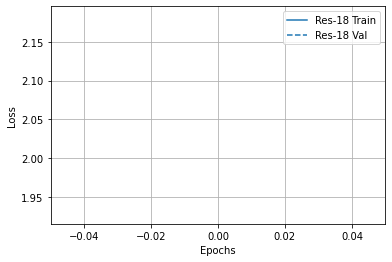

In [14]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter.plot(his)
plt.savefig('train_loss.png')

/usr/local/lib/python3.7/dist-packages/tensorflow_docs/plots/__init__.py:112: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  [0, max([history.epoch[-1] for name, history in histories.items()])])


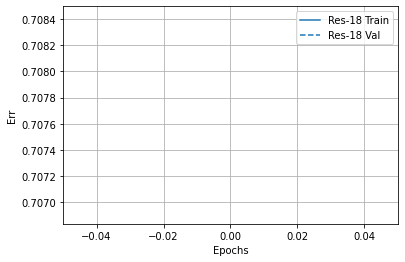

In [15]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'err', smoothing_std=10)
plotter.plot(his)
plt.savefig('train_err.png')

In [16]:
print(model.summary())
test_loss, test_acc = model.evaluate(test_ds)
print(f'test_loss: {test_loss}, test_acc: {test_acc}')

Model: "res_net_on_cifar"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Sequential)          (None, 32, 32, 64)        2048      
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv2_x (Sequential)        (None, 32, 32, 16)        22320     
                                                                 
 conv3_x (Sequential)        (None, 32, 32, 16)        14304     
                                                                 
 conv4_x (Sequential)        (None, 16, 16, 32)        52320     
                                                                 
 conv5_x (Sequential)        (None, 16, 16, 32)        56256     
                                                  